In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

from astroML.utils import completeness_contamination
from astroML.classification import GMMBayes
from astroML.utils import pickle_results

import corner

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [2]:
file = '../solutions/galaxyquasar.csv'
data= np.genfromtxt(file, delimiter=',', dtype = str)
print(data)

[['u' 'g' 'r' ... 'class' 'z1' 'zerr']
 ['18.97213' '18.53676' '18.5828' ... 'QSO' '0.5228189' '0.0001547483']
 ['19.24592' '17.47646' '16.47817' ... 'GALAXY' '0.1228459'
  '2.816076E-05']
 ...
 ['18.62718' '17.30876' '16.87371' ... 'GALAXY' '0.05442934'
  '8.433598E-06']
 ['19.5514' '18.27711' '17.62101' ... 'GALAXY' '0.1125709' '9.286238E-06']
 ['18.80772' '17.75751' '17.405' ... 'GALAXY' '0.04365238' '7.415751E-06']]


In [3]:
#colors
ug = data[1:,0].astype(float) - data[1:,1].astype(float)
gr = data[1:,1].astype(float) - data[1:,2].astype(float)
ri = data[1:,2].astype(float) - data[1:,3].astype(float)
iz = data[1:,3].astype(float) - data[1:,4].astype(float)

galaxies = data[1:,0:4][data[1:,5]=='GALAXY'].astype(float)
quasars = data[1:,0:4][data[1:,5]=='QSO'].astype(float)

labels = np.char.replace(data[1:,5], 'GALAXY', '0')
labels = np.char.replace(labels, 'QSO', '1').astype(float)

In [4]:
ug_train, ug_test, gr_train, gr_test, ri_train, ri_test, iz_train, iz_test, labels_train, labels_test = train_test_split(ug, gr, ri, iz, labels, test_size=0.3)


In [5]:
colors_train = np.column_stack((ug_train, gr_train, ri_train, iz_train))
colors_test = np.column_stack((ug_test, gr_test, ri_test, iz_test))
labels_corner = [r'$u-g$', r'$g-r$', r'$r-i$', r'$i-z$']

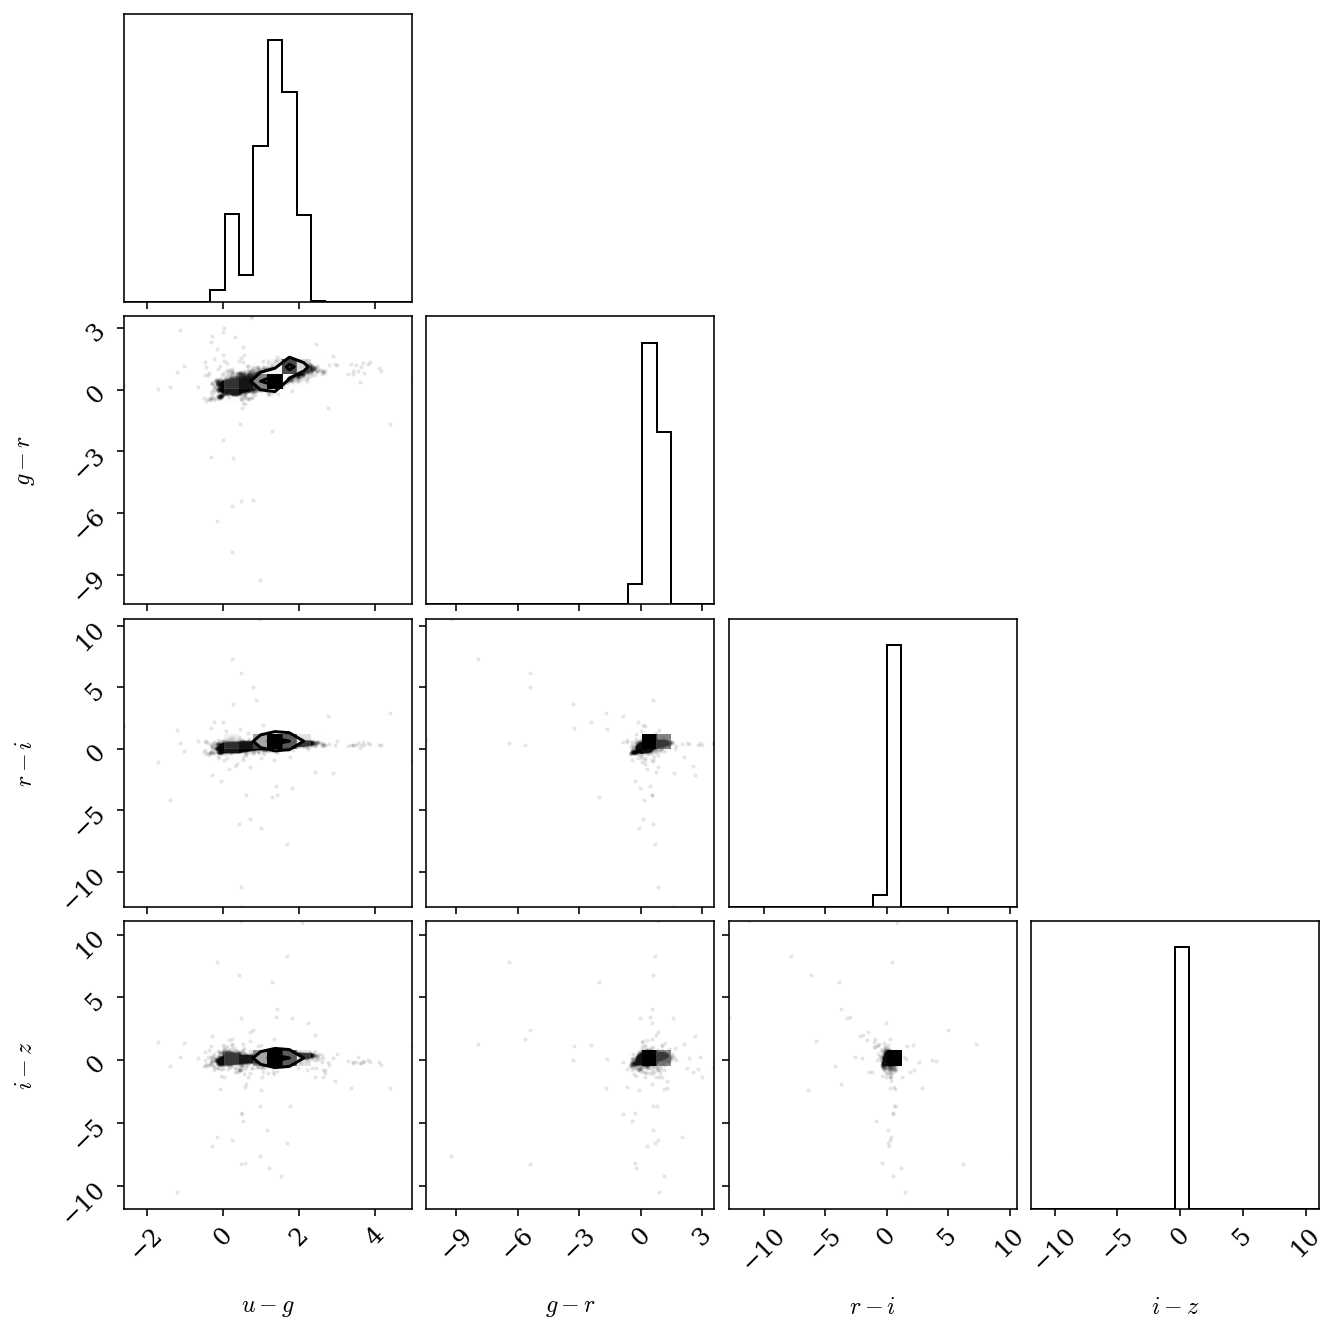

In [6]:
corner.corner(colors_train, labels = labels_corner);

$u-g$ is the most promising color 

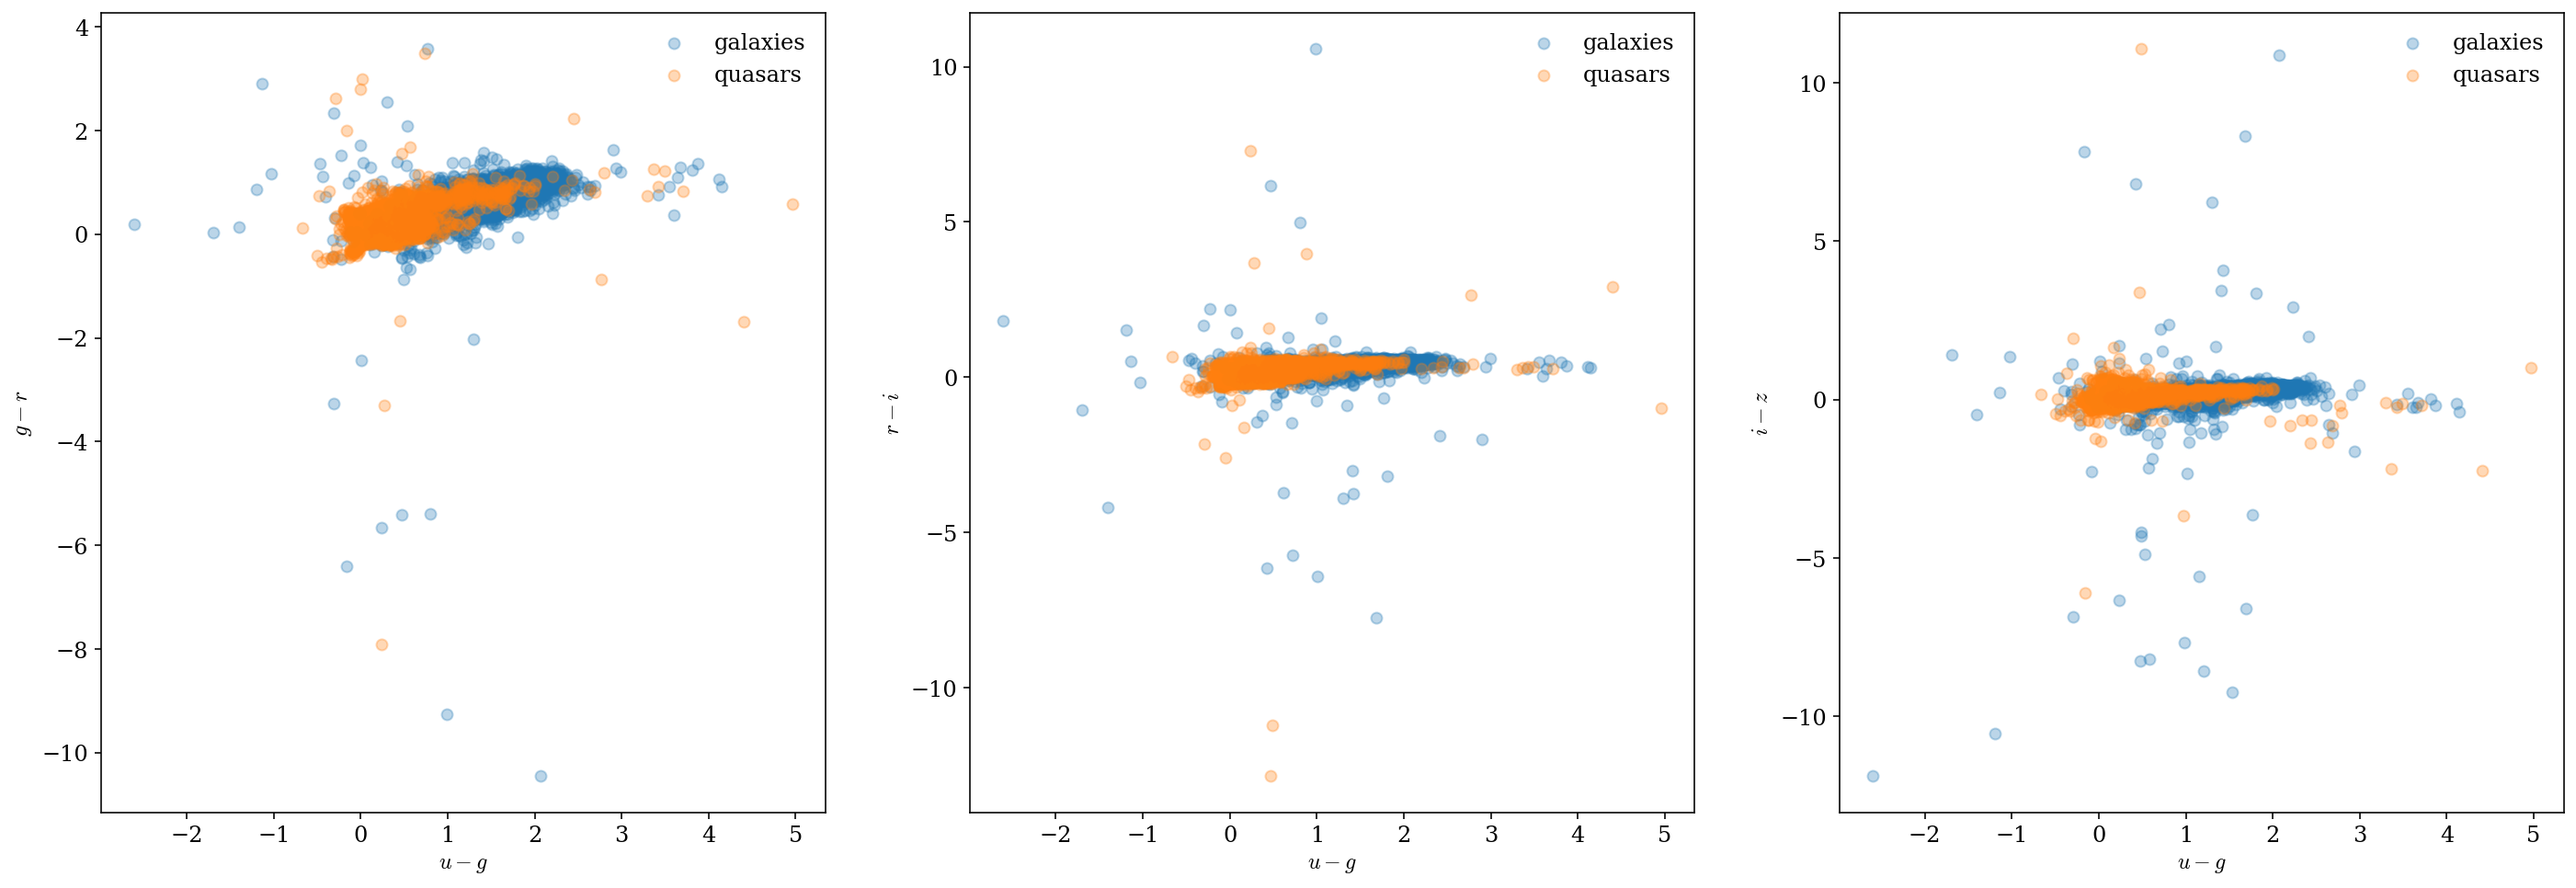

In [7]:
fig, axs = plt.subplots(1,3, figsize = (24,8))

axs[0].scatter(ug_train[labels_train == 0], gr_train[labels_train == 0], alpha=0.3, label='galaxies')
axs[0].scatter(ug_train[labels_train == 1], gr_train[labels_train == 1], alpha=0.3, label='quasars')
axs[0].set_xlabel(r'$u-g$') 
axs[0].set_ylabel(r'$g-r$')
axs[0].legend(frameon = False)

axs[1].scatter(ug_train[labels_train == 0], ri_train[labels_train == 0], alpha=0.3, label='galaxies')
axs[1].scatter(ug_train[labels_train == 1], ri_train[labels_train == 1], alpha=0.3, label='quasars')
axs[1].set_xlabel(r'$u-g$') 
axs[1].set_ylabel(r'$r-i$')
axs[1].legend(frameon = False)

axs[2].scatter(ug_train[labels_train == 0], iz_train[labels_train == 0], alpha=0.3, label='galaxies')
axs[2].scatter(ug_train[labels_train == 1], iz_train[labels_train == 1], alpha=0.3, label='quasars')
axs[2].set_xlabel(r'$u-g$') 
axs[2].set_ylabel(r'$i-z$')
axs[2].legend(frameon = False)

plt.show()

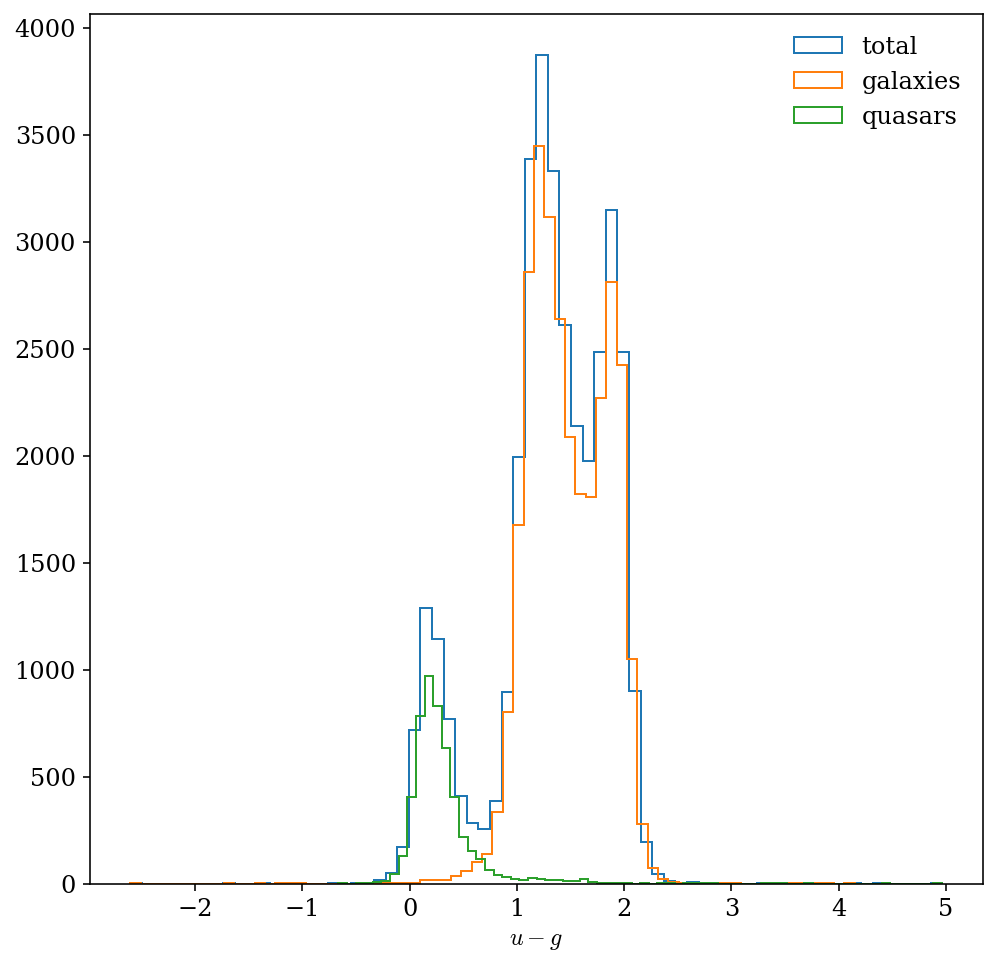

In [8]:
plt.hist(ug_train, bins = 70, histtype = 'step', label='total')
plt.hist(ug_train[labels_train == 0], bins = 70, histtype = 'step', label='galaxies')
plt.hist(ug_train[labels_train == 1], bins = 70, histtype = 'step', label='quasars')

plt.xlabel(r'$u-g$')
plt.legend(frameon = False)
plt.show()

## Classification

In [9]:
def return_accuracy(pred, test):
    true = len(pred[pred == test])
    return true / len(test)

In [10]:
accuracy = [] #best accuracy for each classifier
best_N = [] #number @ which the best accuracy is achieved 

### Gaussian naive bayes

In [11]:
classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1
for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]

    clf = GaussianNB()
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

In [12]:
# Compute the decision boundary
clf = classifiers[1] #2 colors
xlim = (min(X_train[:,0]), max(X_train[:,0]))
ylim = (min(X_train[:,1]), max(X_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

In [13]:
# ROC curve
fpr_list, tpr_list, thresh_list = [], [], []

for proba in labels_proba:
    fpr, tpr, thresh = roc_curve(labels_test, proba) #false and true positive rate + treshold
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresh_list.append(thresh)

In [14]:
#contamination and completeness
completeness, contamination = completeness_contamination(labels_pred, labels_test)
print('completeness: ', completeness)
print('contamination: ', contamination)

completeness:  [0.92256214 0.92734226 0.9206501  0.91969407]
contamination:  [0.07211538 0.11049977 0.10874595 0.12105984]


In [15]:
#accuracy
accuracy_NB = []
for pred in labels_pred:
    acc = return_accuracy(pred, labels_test)
    accuracy_NB.append(acc)
accuracy.append(max(accuracy_NB))
best_N.append(range(1,len(labels_pred)+1)[np.argmax(accuracy_NB)])

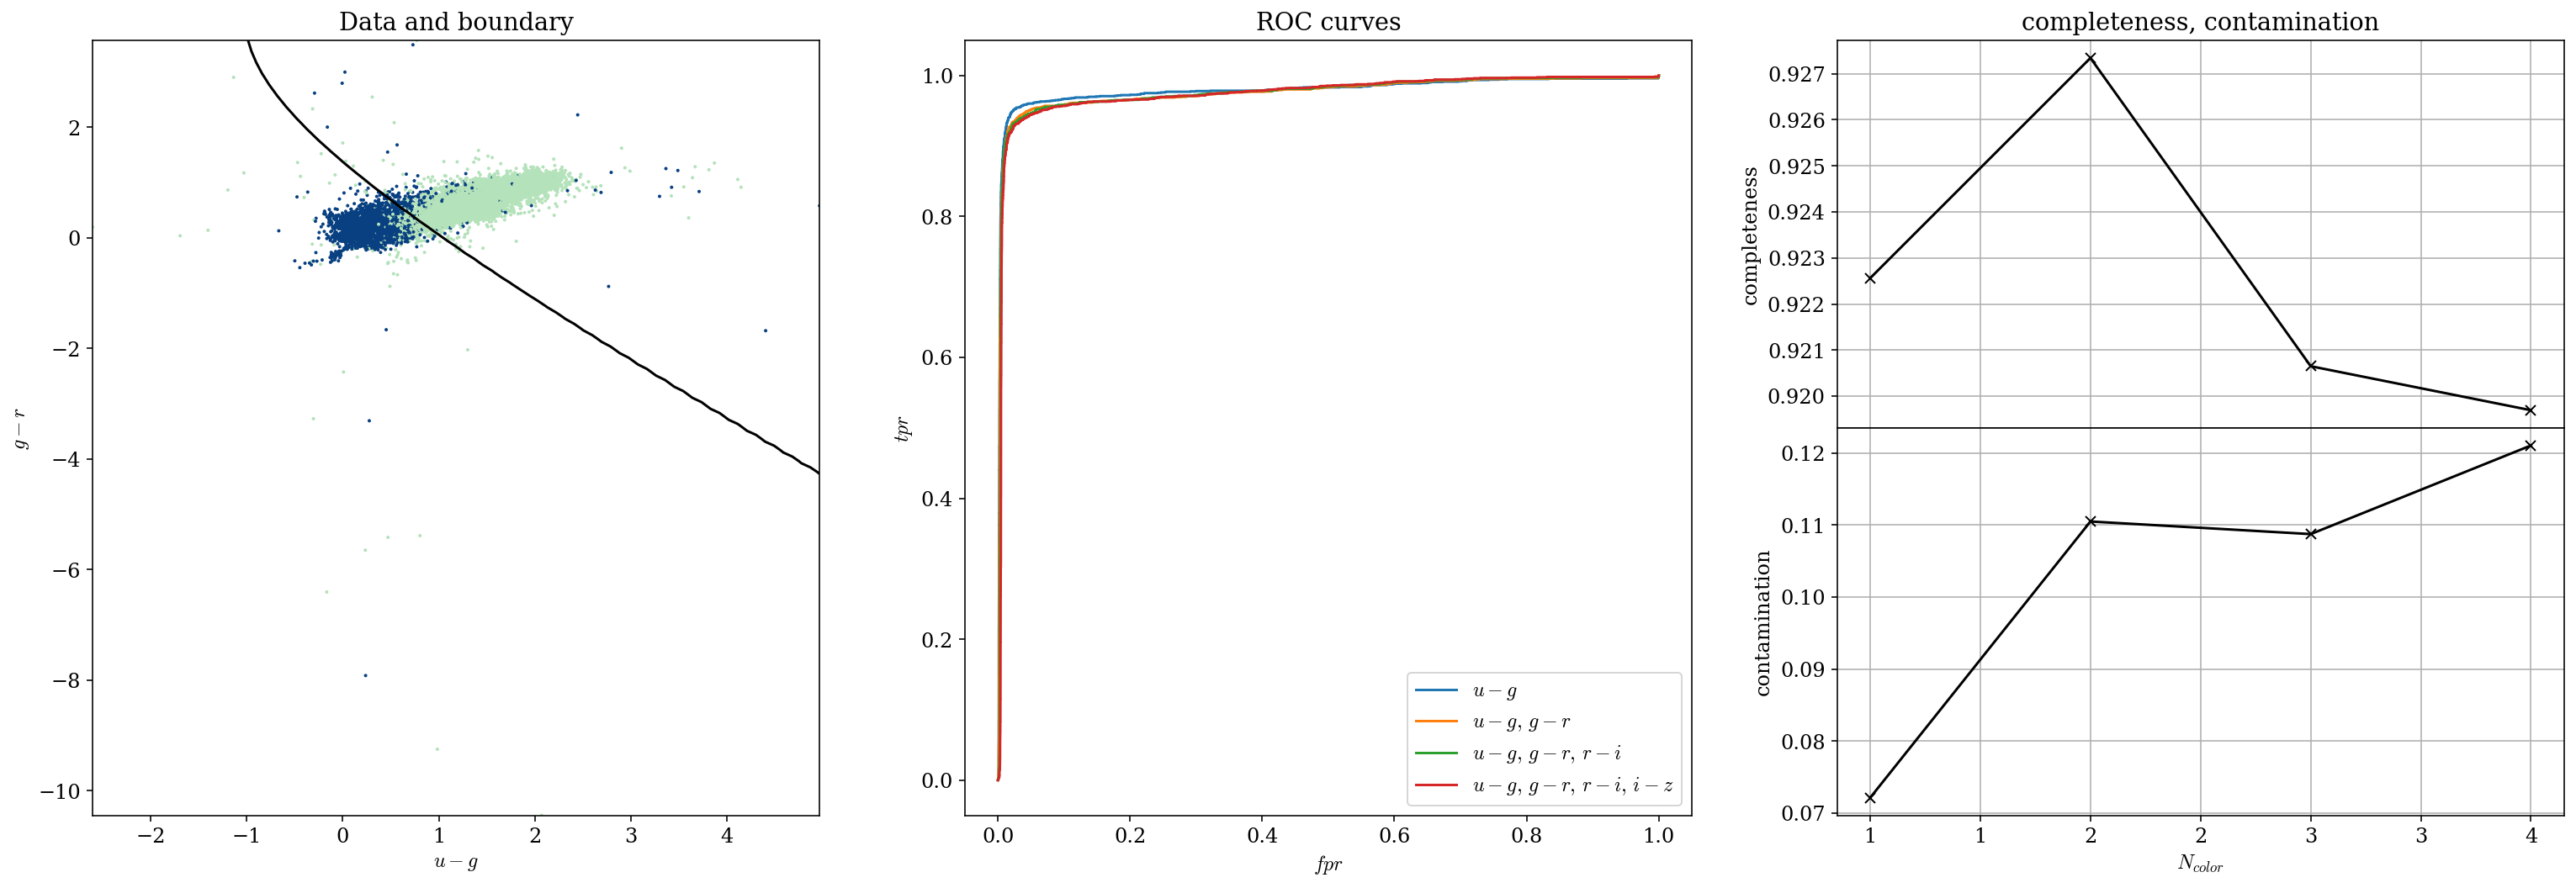

In [16]:
fig = plt.figure(figsize=(24, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)
ax1 = plt.subplot(131) #data: u-g vs g-r
ax2 = plt.subplot(132) #roc curves
ax3 = plt.subplot(233) #completeness
ax4 = plt.subplot(236) #contamination
#------------------------------------------------------------
im = ax1.scatter(X_train[:, 0], X_train[:, 1], c=labels_train,
                s=4, lw=0, cmap=plt.cm.GnBu, zorder=2)
im.set_clim(-0.5, 1)

ax1.contour(xx, yy, Z, [0.5], colors='k')

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

ax1.set_xlabel(r'$u-g$')
ax1.set_ylabel(r'$g-r$')
ax1.set_title('Data and boundary')
#------------------------------------------------------------
labels_plot = [r'$u-g$', r'$u-g, \,g-r$', r'$u-g, \,g-r, \,r-i$', r'$u-g, \,g-r, \,r-i, \,i-z$']
for fpr, tpr, label in zip(fpr_list, tpr_list, labels_plot):
    ax2.plot(fpr, tpr, label = label)
    ax2.legend()
    
ax2.set_xlabel(r'$fpr$')
ax2.set_ylabel(r'$tpr$')
ax2.set_title('ROC curves')
#------------------------------------------------------------
ax3.plot(range(1,N), completeness, 'x-k')
ax3.set_ylabel('completeness')
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_title('completeness, contamination')
ax3.grid(True)
#------------------------------------------------------------
ax4.plot(range(1,N), contamination, 'x-k')
ax4.set_xlabel(r'$N_{color}$')
ax4.set_ylabel('contamination')
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax4.grid(True)
#------------------------------------------------------------
plt.show()

**$u-g$ is the most important feature** (as expected from the corner plot, it's the only color with a relevant variability)

### GMM Bayes

classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1

comp_range = np.arange(1,5) #CV

for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]
    
    grid = GridSearchCV(GMMBayes(), {'n_components': comp_range}, cv=5)
    grid.fit(X_train, labels_train)
    n_opt = grid.best_params_['n_components']

    clf = GMMBayes(n_opt)
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

In [17]:
classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1

for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]
    
    clf = GMMBayes(5)
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

In [18]:
# Compute the decision boundary
clf = classifiers[1] #2 colors
xlim = (min(X_train[:,0]), max(X_train[:,0]))
ylim = (min(X_train[:,1]), max(X_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

In [19]:
# ROC curve
fpr_list, tpr_list, thresh_list = [], [], []

for proba in labels_proba:
    fpr, tpr, thresh = roc_curve(labels_test, proba) #false and true positive rate + treshold
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresh_list.append(thresh)

In [20]:
#contamination and completeness
completeness, contamination = completeness_contamination(labels_pred, labels_test)
print('completeness: ', completeness)
print('contamination: ', contamination)

completeness:  [0.92734226 0.91300191 0.93164436 0.92973231]
contamination:  [0.0783848  0.05445545 0.05571705 0.06804025]


In [21]:
#accuracy
accuracy_GMM = []
for pred in labels_pred:
    acc = return_accuracy(pred, labels_test)
    accuracy_GMM.append(acc)
accuracy.append(max(accuracy_GMM))
best_N.append(range(1,len(labels_pred)+1)[np.argmax(accuracy_GMM)])

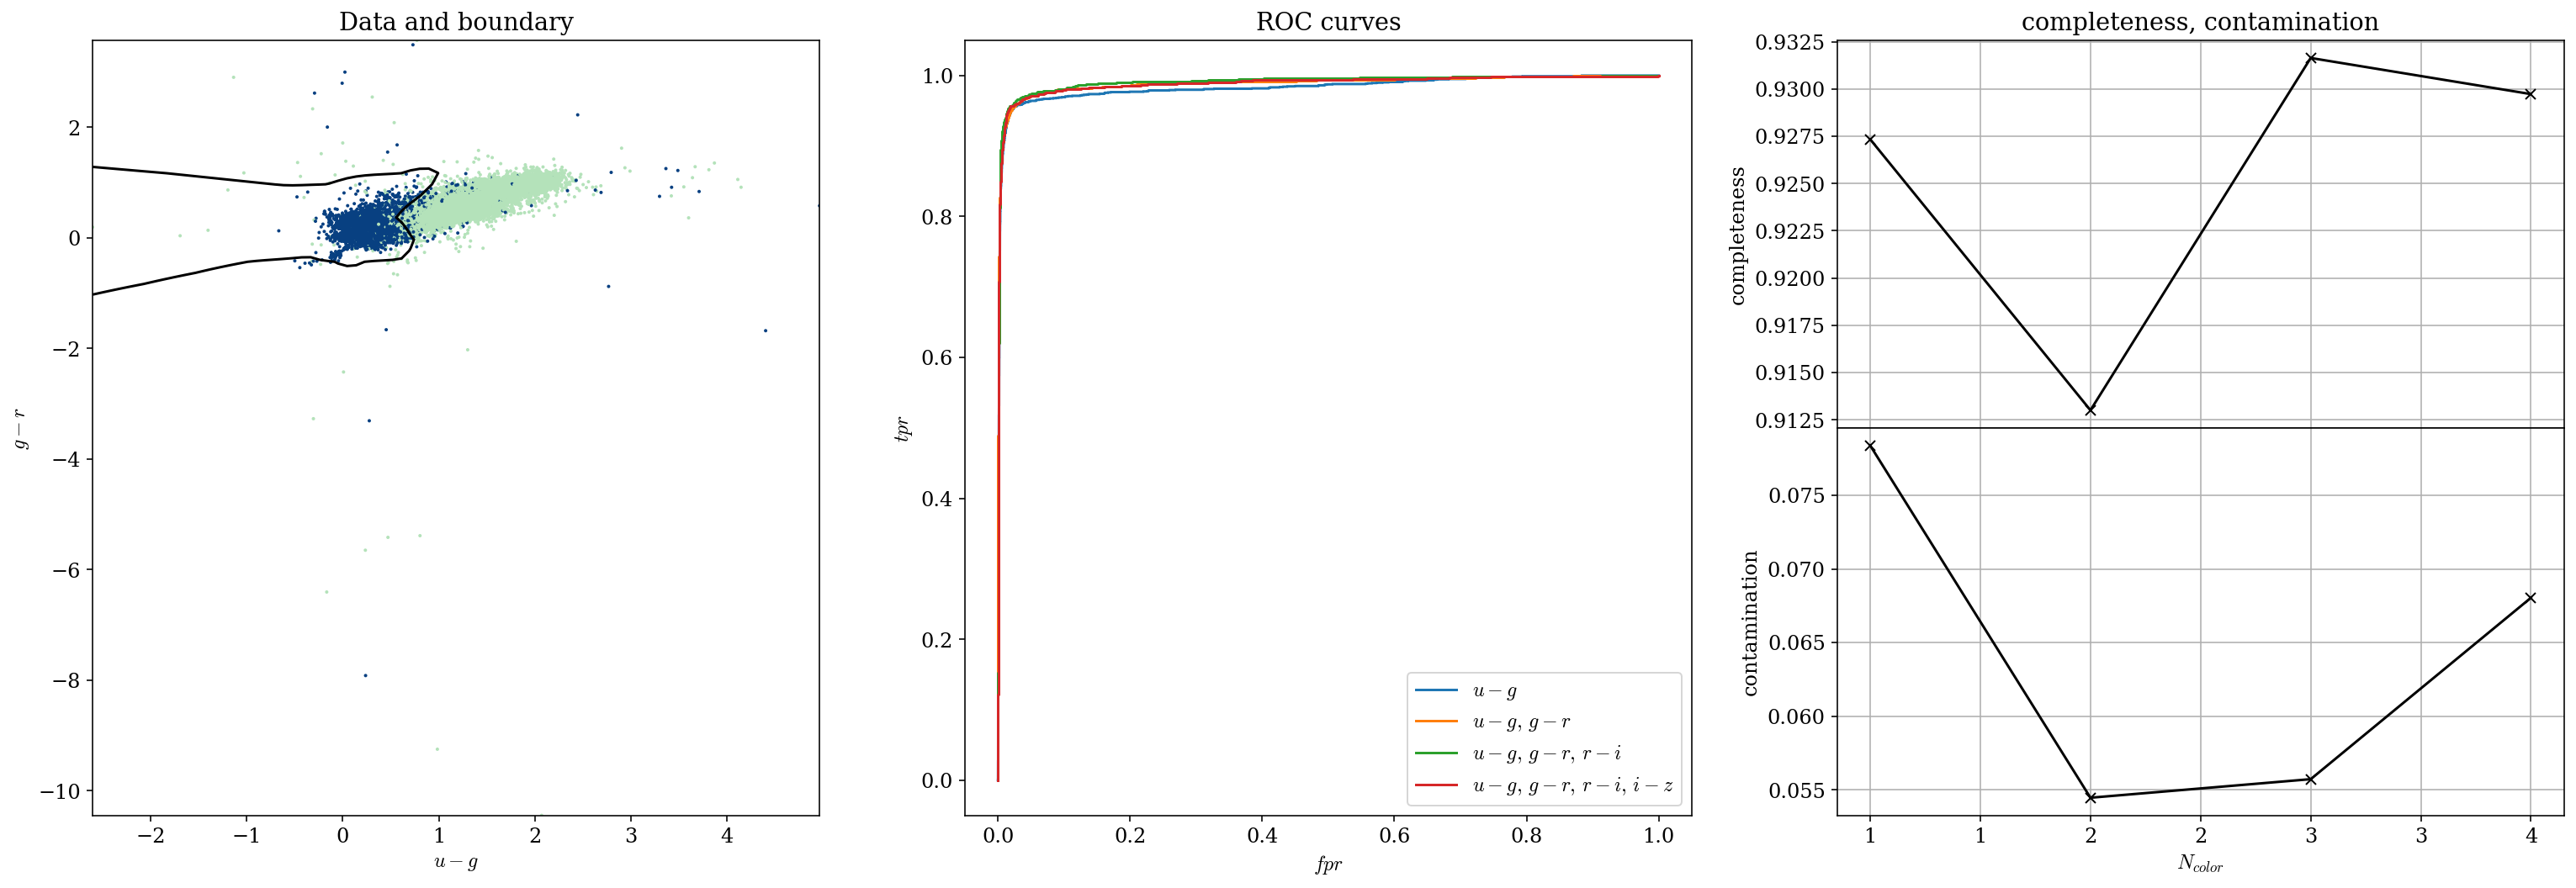

In [22]:
fig = plt.figure(figsize=(24, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)
ax1 = plt.subplot(131) #data: u-g vs g-r
ax2 = plt.subplot(132) #roc curves
ax3 = plt.subplot(233) #completeness
ax4 = plt.subplot(236) #contamination
#------------------------------------------------------------
im = ax1.scatter(X_train[:, 0], X_train[:, 1], c=labels_train,
                s=4, lw=0, cmap=plt.cm.GnBu, zorder=2)
im.set_clim(-0.5, 1)

ax1.contour(xx, yy, Z, [0.5], colors='k')

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

ax1.set_xlabel(r'$u-g$')
ax1.set_ylabel(r'$g-r$')
ax1.set_title('Data and boundary')
#------------------------------------------------------------
labels_plot = [r'$u-g$', r'$u-g, \,g-r$', r'$u-g, \,g-r, \,r-i$', r'$u-g, \,g-r, \,r-i, \,i-z$']
for fpr, tpr, label in zip(fpr_list, tpr_list, labels_plot):
    ax2.plot(fpr, tpr, label = label)
    ax2.legend()
    
ax2.set_xlabel(r'$fpr$')
ax2.set_ylabel(r'$tpr$')
ax2.set_title('ROC curves')
#------------------------------------------------------------
ax3.plot(range(1,N), completeness, 'x-k')
ax3.set_ylabel('completeness')
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_title('completeness, contamination')
ax3.grid(True)
#------------------------------------------------------------
ax4.plot(range(1,N), contamination, 'x-k')
ax4.set_xlabel(r'$N_{color}$')
ax4.set_ylabel('contamination')
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax4.grid(True)
#------------------------------------------------------------
plt.show()

### K-Nearest Neighbor

In [23]:
def CV(X_train, labels_train, kvals):
    grid = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': kvals}, cv = 5)
    grid.fit(X_train, labels_train)
    best_k = grid.best_params_['n_neighbors']
    return best_k

In [24]:
classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1
kvals = np.arange(1,15)
k_used = []
for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]
    #-- CV
    best_k = CV(X_train, labels_train, kvals)
    print(best_k)
    k_used.append(best_k)
    #–-
    clf = KNeighborsClassifier(n_neighbors = best_k)
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

13
14
10
7


In [25]:
# Compute the decision boundary
clf = classifiers[1] #2 colors
xlim = (min(X_train[:,0]), max(X_train[:,0]))
ylim = (min(X_train[:,1]), max(X_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

In [26]:
# ROC curve
fpr_list, tpr_list, thresh_list = [], [], []

for proba in labels_proba:
    fpr, tpr, thresh = roc_curve(labels_test, proba)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresh_list.append(thresh)

In [27]:
#contamination and completeness
completeness, contamination = completeness_contamination(labels_pred, labels_test)
print('completeness: ', completeness)
print('contamination: ', contamination)

completeness:  [0.92112811 0.92208413 0.92304015 0.93451243]
contamination:  [0.06818182 0.05902439 0.04689042 0.04213621]


In [28]:
#accuracy
accuracy_k = []
for pred in labels_pred:
    acc = return_accuracy(pred, labels_test)
    accuracy_k.append(acc)
accuracy.append(max(accuracy_k))
best_N.append(range(1,len(labels_pred) + 1)[np.argmax(accuracy_k)])

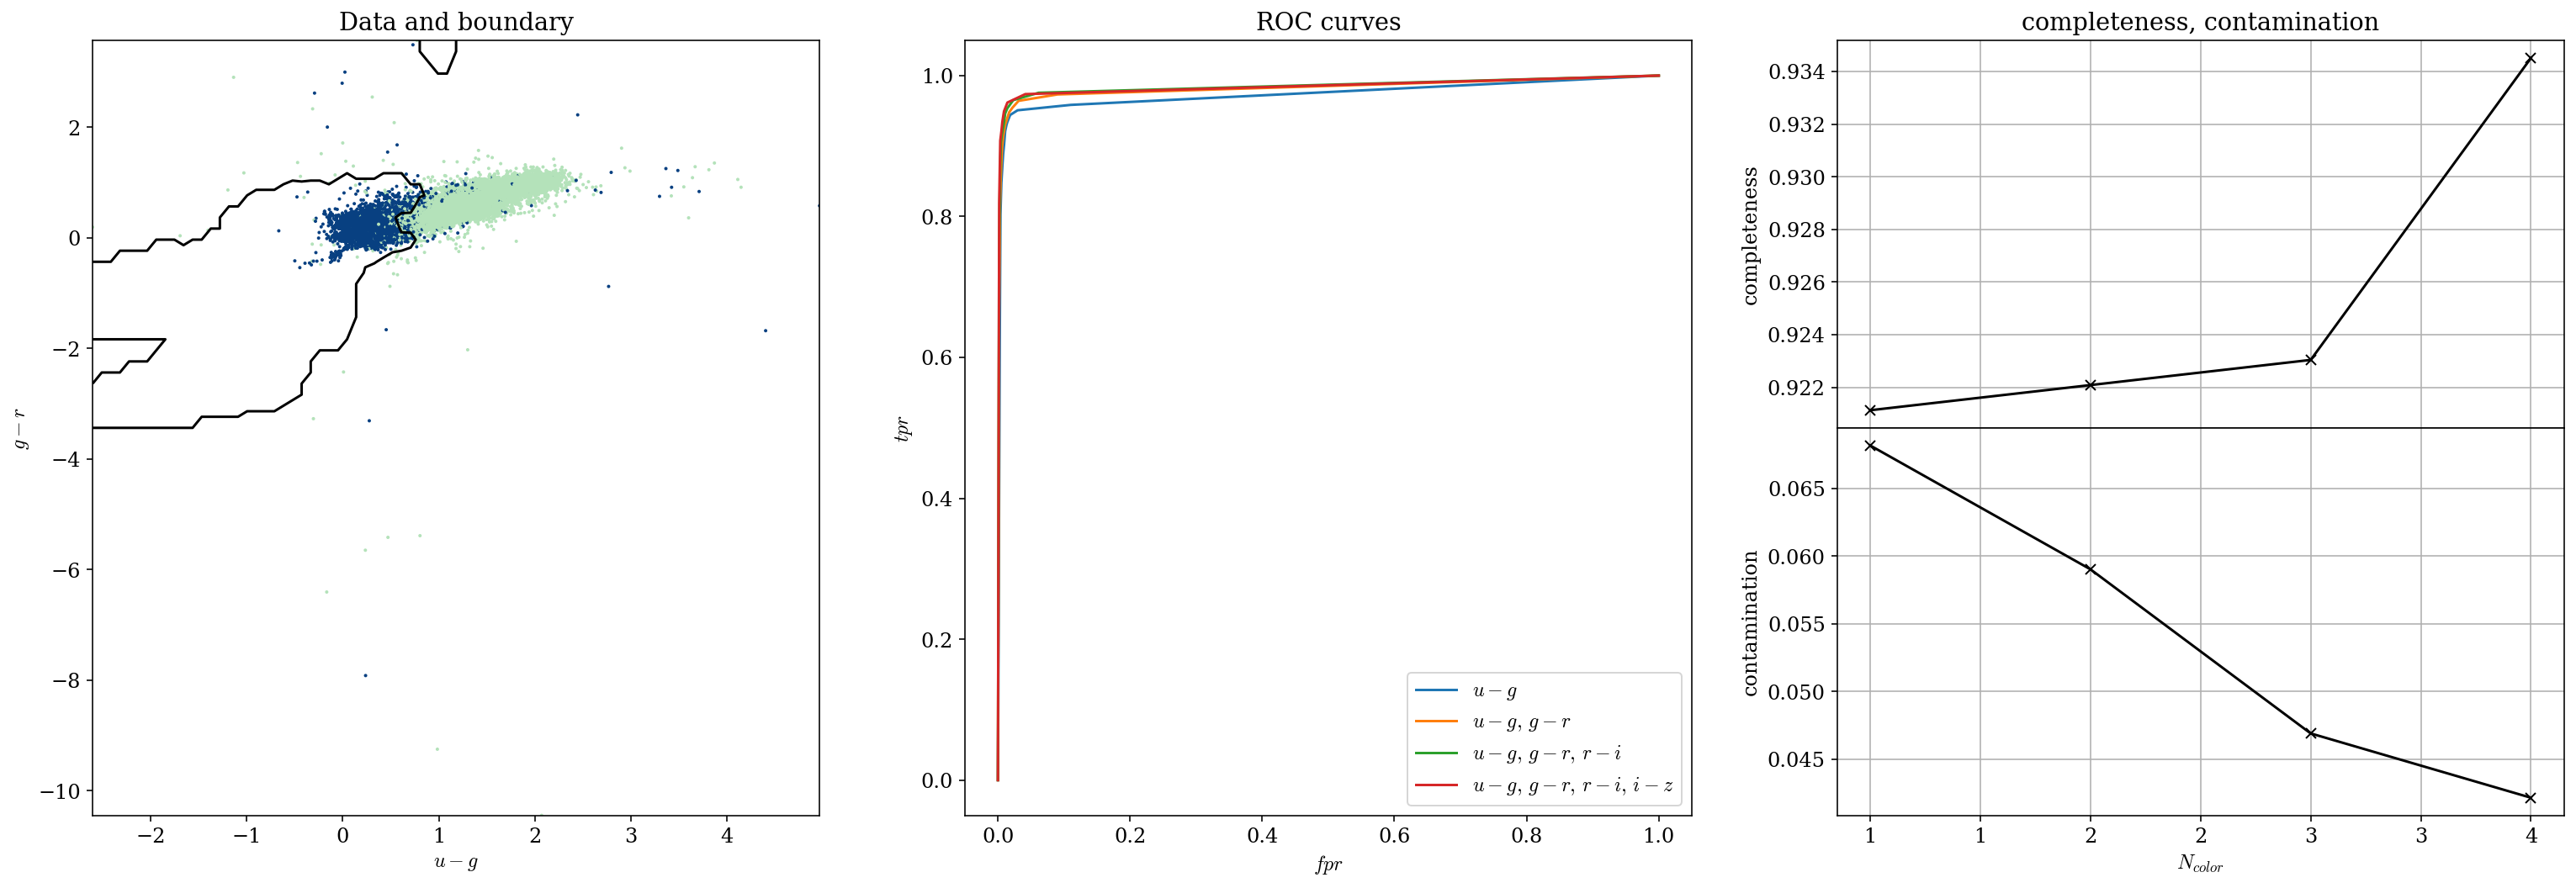

In [29]:
fig = plt.figure(figsize=(24, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)
ax1 = plt.subplot(131) #data: u-g vs g-r
ax2 = plt.subplot(132) #roc curves
ax3 = plt.subplot(233) #completeness
ax4 = plt.subplot(236) #contamination
#------------------------------------------------------------
im = ax1.scatter(X_train[:, 0], X_train[:, 1], c=labels_train,
                s=4, lw=0, cmap=plt.cm.GnBu, zorder=2)
im.set_clim(-0.5, 1)

ax1.contour(xx, yy, Z, [0.5], colors='k')

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

ax1.set_xlabel(r'$u-g$')
ax1.set_ylabel(r'$g-r$')
ax1.set_title('Data and boundary')
#------------------------------------------------------------
labels_plot = [r'$u-g$', r'$u-g, \,g-r$', r'$u-g, \,g-r, \,r-i$', r'$u-g, \,g-r, \,r-i, \,i-z$']
for fpr, tpr, label in zip(fpr_list, tpr_list, labels_plot):
    ax2.plot(fpr, tpr, label = label)
    ax2.legend()
    
ax2.set_xlabel(r'$fpr$')
ax2.set_ylabel(r'$tpr$')
ax2.set_title('ROC curves')
#------------------------------------------------------------
ax3.plot(range(1,N), completeness, 'x-k')
ax3.set_ylabel('completeness')
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_title('completeness, contamination')
ax3.grid(True)
#------------------------------------------------------------
ax4.plot(range(1,N), contamination, 'x-k')
ax4.set_xlabel(r'$N_{color}$')
ax4.set_ylabel('contamination')
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax4.grid(True)
#------------------------------------------------------------
plt.show()

In [30]:
print('The cross validated numbers of neighbors are: ')
for i, k in enumerate(k_used):
    i+=1
    if i == 1:
        print('%i for %i color' % (k,i))
    else:
        print('%i for %i colors' % (k,i))

The cross validated numbers of neighbors are: 
13 for 1 color
14 for 2 colors
10 for 3 colors
7 for 4 colors


In [31]:
methods = ['Gaussian naive bayes', 'GMM Bayes', 'K-Nearest Neighbor']
for name, acc, n in zip(methods, accuracy, best_N):
    print(name + ': accuracy = %.4f for Ncolors = %i' % (acc, n))

Gaussian naive bayes: accuracy = 0.9792 for Ncolors = 1
GMM Bayes: accuracy = 0.9828 for Ncolors = 3
K-Nearest Neighbor: accuracy = 0.9851 for Ncolors = 4


### -----

## TensorFlow  
use all the colors

In [34]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import os
from time import time

In [54]:
#clean the log directory
#!rm -rf ./logs/
#!rm -rf ./logsL19_trained/

#trained model
#!rm -rf ./L19_trained.h5

In [55]:
#hyperparameters: CV the number of neurons, the activation function and the lr
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete(np.arange(1, 2*len(colors_train[0]) + 1).tolist()))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete(np.linspace(1e-3, 1e-1, 10).tolist()))
HP_ACT_FUNCTION = hp.HParam('activation', hp.Discrete(['relu', 'tanh']))
METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/L19_hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_LEARNING_RATE, HP_ACT_FUNCTION],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [60]:
#functions
#---
def rescale_colors(colors):
    rescaled_colors = np.zeros_like(colors)
    for i in range(len(colors[0])):
        lims = min(colors[:,i]), max(colors[:,i])
        rescaled_colors[:,i] = 1 - 2 * (colors[:, i] - lims[0]) / (lims[1] - lims[0])
    return rescaled_colors
#---
#CV for the hyperparams
def train_test_model(colors_train, labels_train, colors_test, labels_test, hparams):

    train_in  = rescale_colors(colors_train)
    train_out = labels_train
    test_in  = rescale_colors(colors_test)
    test_out = labels_test

    # Kernel initializer
    my_init = tf.keras.initializers.glorot_uniform(seed=1)
    # Define neural network architecture
    model = tf.keras.Sequential([
        # Input layer, do not change
        tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
        # Inner layers, can add/change
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=hparams[HP_ACT_FUNCTION], kernel_initializer=my_init),
        # Output layer, do not change
        tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE]),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    model.fit(colors_train, labels_train, epochs=5) 
    _, accuracy = model.evaluate(colors_test, labels_test)
    return accuracy
#---
def run(run_dir, colors_train, labels_train, colors_test, labels_test, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(colors_train, labels_train, colors_test, labels_test, hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
    return accuracy
#---
def trainnetwork(colors_train, labels_train, colors_test, labels_test, hparams, filename='L19_trained.h5'):

    if not os.path.isfile(filename):

        train_in  = rescale_colors(colors_train)
        train_out = labels_train
        test_in  = rescale_colors(colors_test)
        test_out = labels_test

        # Kernel initializer
        my_init = tf.keras.initializers.glorot_uniform(seed=1)
        # Define neural network architecture
        model = tf.keras.Sequential([
            # Input layer, do not change
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            # Inner layers, can add/change
            tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=hparams[HP_ACT_FUNCTION], kernel_initializer=my_init),
            # Output layer, do not change
            tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])
    
    
        model.compile(
            # Optimization algorithm
            optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE]),
            # Loss function for a binary classifier
            loss='binary_crossentropy',
            # Diagnostic quantities
            metrics=['accuracy'])

        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return lr * tf.math.exp(-0.05)

        # Actual Training
        history = model.fit(
            # Training inputs
            train_in,
            # Training outputs
            train_out,
            # Evaluate test set at each epoch
            validation_data=(test_in, test_out),
            # Batch size, default is 32
            #batch_size=32,
            # Number of epochs
            epochs=150,
            # Store the model with the best validation accuracy
            callbacks = [
                # Drecrease learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                # Store the model with the best validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                # Save logfiles for tensorboard
                tf.keras.callbacks.TensorBoard(log_dir="logs"+filename.split('.h5')[0], histogram_freq=1)],
            # Shuffle data at each epoch
            shuffle=True)

    model = loadnetwork(filename)
    return model
#---
def loadnetwork(filename,verbose=False):
    '''
    Load a trained neural network
    '''

    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()

    return model
#---
def testnetwork(model, colors_test, labels_test):
    '''
    Test network 
    '''
    test_in  = rescale_colors(colors_test)
    test_out = labels_test
    model.evaluate(test_in,  test_out, verbose=2)
#---
def predictnetwork(model, colors_test):
    '''
    Use a network to predict the class.
    '''
    # Return the class (0 or 1) that is preferred
    predictions = np.squeeze((model.predict(rescale_colors(colors_test)) > 0.5).astype("int32"))
    return predictions

In [61]:
#trained file:
filename='L19_trained.h5'

how much does the CV on a grid take? 

In [58]:
hparams = {
            HP_NUM_UNITS: 0,
            HP_LEARNING_RATE: 0,
            HP_ACT_FUNCTION: 0
        }
#VALIDATION
if not os.path.isfile(filename):
    tmp = time()
    accuracy_best = 0
    session_num = 0

    for num_units in HP_NUM_UNITS.domain.values:
        for lr in HP_LEARNING_RATE.domain.values:
            for activation in HP_ACT_FUNCTION.domain.values:
                hparams = {
                    HP_NUM_UNITS: num_units,
                    HP_LEARNING_RATE: lr,
                    HP_ACT_FUNCTION: activation
                }
                run_name = "run-%d" % session_num
                print('--- Starting trial: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                accuracy_try = run('logs/hparam_tuning/' + run_name, colors_train, labels_train, colors_test, labels_test, hparams)
                session_num += 1
        
                if accuracy_try > accuracy_best:
                    accuracy_best = accuracy_try
                    best_num_units = num_units
                    best_lr = lr
                    best_activation = activation
            
    hparams = {
            HP_NUM_UNITS: best_num_units,
            HP_LEARNING_RATE: best_lr,
            HP_ACT_FUNCTION: best_activation
        }
    print(hparams)
    print(accuracy_best)
    
    tmp = time() - tmp
    print('---- \nThe cross validation took %.2f s' % tmp)

--- Starting trial: run-0
{'num_units': 1, 'learning_rate': 0.001, 'activation': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.5608 - accuracy: 0.8559
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4412 - accuracy: 0.8559
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4162 - accuracy: 0.8559
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4127 - accuracy: 0.8559
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.4041 - accuracy: 0.8605
--- Starting trial: run-1
{'num_units': 1, 'learning_rate': 0.001, 'activation': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.3067 - accuracy: 0.8720
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1662 - accuracy: 0.9629
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1098 - accuracy: 0.9787
Epoch 4/5
1094/1

469/469 [==============================] - 1s 2ms/step - loss: 0.0727 - accuracy: 0.9824
--- Starting trial: run-12
{'num_units': 1, 'learning_rate': 0.067, 'activation': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0981 - accuracy: 0.9775
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0790 - accuracy: 0.9814
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0777 - accuracy: 0.9821
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0794 - accuracy: 0.9815
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0863 - accuracy: 0.9779
--- Starting trial: run-13
{'num_units': 1, 'learning_rate': 0.067, 'activation': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0869 - accuracy: 0.9751
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0682 - accuracy: 0.9830
Epoch 3/5
1094/1094 [=====

469/469 [==============================] - 1s 1ms/step - loss: 0.0637 - accuracy: 0.9821
--- Starting trial: run-24
{'num_units': 2, 'learning_rate': 0.023000000000000003, 'activation': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1094 - accuracy: 0.9695
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0825 - accuracy: 0.9827
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0822 - accuracy: 0.9829
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0823 - accuracy: 0.9829
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0888 - accuracy: 0.9793
--- Starting trial: run-25
{'num_units': 2, 'learning_rate': 0.023000000000000003, 'activation': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0833 - accuracy: 0.9767
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0626 - accuracy: 0.9

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0631 - accuracy: 0.9845
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0639 - accuracy: 0.9831
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0656 - accuracy: 0.9827
--- Starting trial: run-36
{'num_units': 2, 'learning_rate': 0.08900000000000001, 'activation': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.3213 - accuracy: 0.8903
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0817 - accuracy: 0.9816
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0814 - accuracy: 0.9814
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0767 - accuracy: 0.9821
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0842 - accuracy: 0.9781
--- Starting trial: run-37
{'num_units': 2, 'learning_rate': 0.08900000000000001, 'activation': 'tanh'

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0617 - accuracy: 0.9842
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0607 - accuracy: 0.9841
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0604 - accuracy: 0.9844
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0600 - accuracy: 0.9833
--- Starting trial: run-48
{'num_units': 3, 'learning_rate': 0.045000000000000005, 'activation': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0856 - accuracy: 0.9790
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0779 - accuracy: 0.9813
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0770 - accuracy: 0.9813
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0755 - accuracy: 0.9819
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0792 - accuracy: 0.9799


Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0731 - accuracy: 0.9809
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0653 - accuracy: 0.9833
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9827
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0646 - accuracy: 0.9829
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0632 - accuracy: 0.9826
--- Starting trial: run-60
{'num_units': 4, 'learning_rate': 0.001, 'activation': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4405 - accuracy: 0.7409
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2129 - accuracy: 0.8701
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1502 - accuracy: 0.9545
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1146 - accuracy: 0.9761
Epo

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0719 - accuracy: 0.9809
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0620 - accuracy: 0.9838
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0613 - accuracy: 0.9844
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0600 - accuracy: 0.9848
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0622 - accuracy: 0.9829
--- Starting trial: run-72
{'num_units': 4, 'learning_rate': 0.067, 'activation': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0868 - accuracy: 0.9801
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0820 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0798 - accuracy: 0.9821
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0774 - accuracy: 0.9812
Epo

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1337 - accuracy: 0.9494
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0655 - accuracy: 0.9837
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0637 - accuracy: 0.9837
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0627 - accuracy: 0.9841
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0634 - accuracy: 0.9819
--- Starting trial: run-84
{'num_units': 5, 'learning_rate': 0.023000000000000003, 'activation': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0961 - accuracy: 0.9764
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0833 - accuracy: 0.9828
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0830 - accuracy: 0.9829
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0794 - accur

469/469 [==============================] - 1s 1ms/step - loss: 0.0765 - accuracy: 0.9788
--- Starting trial: run-95
{'num_units': 5, 'learning_rate': 0.07800000000000001, 'activation': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0760 - accuracy: 0.9785
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9841
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0620 - accuracy: 0.9837
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0614 - accuracy: 0.9845
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0606 - accuracy: 0.9824
--- Starting trial: run-96
{'num_units': 5, 'learning_rate': 0.08900000000000001, 'activation': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0905 - accuracy: 0.9805
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0824 - accuracy: 0.981

469/469 [==============================] - 1s 1ms/step - loss: 0.0681 - accuracy: 0.9805
--- Starting trial: run-107
{'num_units': 6, 'learning_rate': 0.034, 'activation': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0835 - accuracy: 0.9736
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0621 - accuracy: 0.9838
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0611 - accuracy: 0.9838
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0601 - accuracy: 0.9841
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0597 - accuracy: 0.9827
--- Starting trial: run-108
{'num_units': 6, 'learning_rate': 0.045000000000000005, 'activation': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1059 - accuracy: 0.9713
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0690 - accuracy: 0.9828
Epoch 3/5

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0803 - accuracy: 0.9817
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0768 - accuracy: 0.9821
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0835 - accuracy: 0.9800
--- Starting trial: run-119
{'num_units': 6, 'learning_rate': 0.1, 'activation': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0696 - accuracy: 0.9818
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0629 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0631 - accuracy: 0.9840
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9841
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0656 - accuracy: 0.9827
--- Starting trial: run-120
{'num_units': 7, 'learning_rate': 0.001, 'activation': 'relu'}
Epoch 1/5
1094/1094 [=====

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0810 - accuracy: 0.9820
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0803 - accuracy: 0.9822
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0722 - accuracy: 0.9829
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1084 - accuracy: 0.9811
--- Starting trial: run-131
{'num_units': 7, 'learning_rate': 0.05600000000000001, 'activation': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0741 - accuracy: 0.9787
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0610 - accuracy: 0.9840
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0599 - accuracy: 0.9848
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0597 - accuracy: 0.9844
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0611 - accuracy: 0.9821


1094/1094 [==============================] - 2s 2ms/step - loss: 0.0851 - accuracy: 0.9777
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0709 - accuracy: 0.9829
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0693 - accuracy: 0.9835
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0671 - accuracy: 0.9837
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0718 - accuracy: 0.9817
--- Starting trial: run-143
{'num_units': 8, 'learning_rate': 0.012, 'activation': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0915 - accuracy: 0.9721
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0663 - accuracy: 0.9834
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9837
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0614 - accuracy: 0.9842
Epoch 5/5
46

469/469 [==============================] - 1s 1ms/step - loss: 0.0583 - accuracy: 0.9833
--- Starting trial: run-154
{'num_units': 8, 'learning_rate': 0.07800000000000001, 'activation': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0910 - accuracy: 0.9777
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0842 - accuracy: 0.9828
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0734 - accuracy: 0.9827
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0831 - accuracy: 0.9820
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0775 - accuracy: 0.9807
--- Starting trial: run-155
{'num_units': 8, 'learning_rate': 0.07800000000000001, 'activation': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0697 - accuracy: 0.9824
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0623 - accuracy: 0.9

In [62]:
model = trainnetwork(colors_train, labels_train, colors_test, labels_test, hparams, filename=filename)

Epoch 1/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0869 - accuracy: 0.9768 - val_loss: 0.2640 - val_accuracy: 0.8984 - lr: 0.0450
Epoch 2/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0724 - accuracy: 0.9814 - val_loss: 0.3563 - val_accuracy: 0.8566 - lr: 0.0450
Epoch 3/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0701 - accuracy: 0.9823 - val_loss: 0.1098 - val_accuracy: 0.9669 - lr: 0.0450
Epoch 4/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0687 - accuracy: 0.9826 - val_loss: 0.0976 - val_accuracy: 0.9748 - lr: 0.0450
Epoch 5/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0678 - accuracy: 0.9828 - val_loss: 0.1252 - val_accuracy: 0.9616 - lr: 0.0450
Epoch 6/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0677 - accuracy: 0.9829 - val_loss: 0.1098 - val_accuracy: 0.9629 - lr: 0.0450
Epoch 7/150
1094/1094 [=============================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0598 - accuracy: 0.9845 - val_loss: 0.4858 - val_accuracy: 0.8872 - lr: 0.0055
Epoch 53/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0599 - accuracy: 0.9845 - val_loss: 0.4393 - val_accuracy: 0.8993 - lr: 0.0052
Epoch 54/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0599 - accuracy: 0.9844 - val_loss: 0.3158 - val_accuracy: 0.9349 - lr: 0.0050
Epoch 55/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0598 - accuracy: 0.9842 - val_loss: 0.4474 - val_accuracy: 0.9040 - lr: 0.0047
Epoch 56/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0598 - accuracy: 0.9845 - val_loss: 0.4728 - val_accuracy: 0.8943 - lr: 0.0045
Epoch 57/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0598 - accuracy: 0.9845 - val_loss: 0.4042 - val_accuracy: 0.9171 - lr: 0.0043
Epoch 58/150
1094/1094 [==============================] - 2

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0593 - accuracy: 0.9846 - val_loss: 0.3991 - val_accuracy: 0.9161 - lr: 4.3027e-04
Epoch 104/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0593 - accuracy: 0.9846 - val_loss: 0.3975 - val_accuracy: 0.9170 - lr: 4.0929e-04
Epoch 105/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0593 - accuracy: 0.9846 - val_loss: 0.3935 - val_accuracy: 0.9180 - lr: 3.8933e-04
Epoch 106/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0593 - accuracy: 0.9846 - val_loss: 0.3908 - val_accuracy: 0.9189 - lr: 3.7034e-04
Epoch 107/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0593 - accuracy: 0.9846 - val_loss: 0.3902 - val_accuracy: 0.9193 - lr: 3.5228e-04
Epoch 108/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0593 - accuracy: 0.9846 - val_loss: 0.3935 - val_accuracy: 0.9185 - lr: 3.3510e-04
Epoch 109/150
1094/1094 [=====

In [63]:
testnetwork(model, colors_test, labels_test)

469/469 - 1s - loss: 0.0976 - accuracy: 0.9748 - 615ms/epoch - 1ms/step


In [64]:
labels_pred = predictnetwork(model, colors_test)
accuracy = return_accuracy(labels_pred, labels_test)
print('accuracy of the nn: ', accuracy)

accuracy of the nn:  0.9748


In [65]:
%tensorboard --logdir logs/hparam_tuning